<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/ML_Denoising_21_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Machine Learning

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas
import numpy as np
from math import log10, sqrt, ceil
import os, shutil
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats
import keras.backend as K
from keras.applications.vgg19 import VGG19

from pycocotools.coco import COCO
import skimage.io as io
from skimage.metrics import structural_similarity as ssim

import sys

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 47 kB/s 
     |████████████████████████████████| 2.9 MB 51.9 MB/s 
     |████████████████████████████████| 459 kB 50.1 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting u

In [ ]:
!pip install tensorflow==2.3.0

## Import COCO dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataDir='drive/MyDrive/ML-denoising'
dataType='val2017'
annFile='{}/annotations/stuff_{}.json'.format(dataDir,dataType)
print(annFile)
# initialize COCO api for instance annotations
coco=COCO(annFile)

drive/MyDrive/ML-denoising/annotations/stuff_val2017.json
loading annotations into memory...
Done (t=4.13s)
creating index...
index created!


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms = set([cat['supercategory'] for cat in cats])
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds = catIds );
imgIds = coco.getImgIds(imgIds = imgIds)

### Download and load Dataset

Saving images as array of values between [-1,1]

Images are randomly cropped into a window of size (256,256)

In [6]:
# utility function to plot some figures
def plot_figures(x, n, figsize=(20,20), dpi=20):
  plt.figure(figsize=figsize)
  if n == 1:
    img=x[:,:,:]
    # rescale for visualization purposes
    img = ((img*127.5) + 127.5).astype("uint8")
    plt.imshow(img)
  else:
    for i in range(n):

      plt.subplot(1,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img=x[i,:,:,:]
      # rescale for visualization purposes
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)

  plt.show()

In [7]:
def set_directories(d_source):
  # Create directories if are not not present 

  d_dataset='dataset'
  path_dataset = os.path.join(d_source, d_dataset)
  if(not os.path.exists(path_dataset)):
    os.mkdir(path_dataset)

  d_test_dataset='test'
  path_test = os.path.join(path_dataset, d_test_dataset)
  if(not os.path.exists(path_test)):
    os.mkdir(path_test)

  d_train_dataset='train'
  path_train = os.path.join(path_dataset, d_train_dataset)
  if(not os.path.exists(path_train)):
    os.mkdir(path_train)

  return path_train, path_test

In [8]:
def is_dataset_on_drive(d_source):
  d_dataset='dataset'
  path_dataset = os.path.join(d_source, d_dataset)
  if(not os.path.exists(path_dataset)):
    print(" [LOAD]: No dataset on Drive.") 
    return False, "", ""
  
  d_test_dataset='test'
  path_test = os.path.join(path_dataset, d_test_dataset)
  if(not os.path.exists(path_test)):
    print(" [LOAD]: No test set on Drive.") 
    return False, "", ""
  
  d_train_dataset='train'
  path_train = os.path.join(path_dataset, d_train_dataset)
  if(not os.path.exists(path_train)):
    print(" [LOAD]: No train set on Drive.") 
    return False, "", ""
  
  return True, path_test, path_train  

In [9]:
def reset_datasets(path_train, path_test, ram_parallel):
  # Reset datasets from path
  if((not os.path.exists(path_train)) and (not os.path.exists(path_test))):
    print(" [LOAD]: No train and test datasets found.")
    return

  i=0
  while True:
    path_i="train"+str(i)+".npy"
    path_train_i=os.path.join(path_train, path_i)
    if(os.path.exists(path_train_i)):
      os.remove(path_train_i)
      i=i+1
    else:
      break
  i=0
  while True:
    path_i="test"+str(i)+".npy"
    path_test_i=os.path.join(path_test, path_i)
    if(os.path.exists(path_test_i)):
      os.remove(path_test_i)
      i=i+1
    else:
      break

  return 

In [10]:
def calculate_range(image_count_train, image_count_test, ram_parallel):
  max_images_on_file=np.zeros((2, max(ram_parallel[0], ram_parallel[1])))

  max_range_on_file=ceil(image_count_test/ram_parallel[1])
  for i in range(ram_parallel[1]):
    if image_count_test-max_range_on_file < 0 :
      max_images_on_file[1][i]=int(image_count_test)
      break
    else:
      max_images_on_file[1][i]=int(max_range_on_file)
      image_count_test=image_count_test-max_range_on_file

  for i in range(ram_parallel[1]):
    if max_images_on_file[1][i]==0 :
      ram_parallel[1]=i
      break

  max_range_on_file=ceil(image_count_train/ram_parallel[0])
  for i in range(ram_parallel[0]):
    if image_count_train-max_range_on_file < 0 :
      max_images_on_file[0][i]=image_count_train
      break
    else:
      max_images_on_file[0][i]=max_range_on_file
      image_count_train=image_count_train-max_range_on_file
    
  for i in range(ram_parallel[0]):
    if max_images_on_file[0][i]==0 :
      ram_parallel[0]=i
      break

  return max_images_on_file

In [11]:
def print_calculated_range(max_images_on_file, ram_parallel):
  count_test=0
  count_train=0

  string_train=" [META]: "
  for i in range(ram_parallel[0]):
    string_train=string_train+"train"+str(i)+":["+str(int(max_images_on_file[0][i]))+"]"
    if i is not ram_parallel[0]-1:
      string_train=string_train+" "
    count_train=count_train+int(max_images_on_file[0][i])
  string_train=string_train+"]"
  print(string_train)
  print(" [META]: Count train: "+str(count_train))

  string_test=" [META]: "
  for i in range(ram_parallel[1]):
    string_test=string_test+"test"+str(i)+":["+str(int(max_images_on_file[1][i]))+"]"
    if i is not ram_parallel[1]-1:
      string_test=string_test+" "
    count_test=count_test+int(max_images_on_file[1][i])
  string_test=string_test+"]"
  print(string_test)
  print(" [META]: Count test: "+str(count_test))

  return

In [12]:
def load_dataset_from_drive(d_source, n, image_count_train, image_count_test, ram_parallel, max_images_on_file):
  
  check, path_test, path_train=is_dataset_on_drive(d_source)
  if check is not True:
    print(" [LOAD]: You need to download COCO Dataset from API and upload on Drive.")
    return
  
  print(" [LOAD]: Loading test set...")

  ##### TEST SET #####
  test=np.zeros((image_count_test, n, n, 3)) # values between [-1,1]
  i=0
  j=0

  for i in range(ram_parallel[1]):
    k=int(max_images_on_file[1][i])
  
    path_i="test"+str(i)+".npy"
    path_test_i=os.path.join(path_test, path_i)
    if(not os.path.exists(path_test_i)):
      break

    test[j:j+k]=np.load(path_test_i)
    j=j+k

    percentage = "{:.2%}".format(j/image_count_test)
    message="[LOAD]: Test dataset load process: "+percentage
    print("\r", message, end="")

  print(" ")
  print(" [LOAD]: Completed.")
  print("**********************************************************************************")
  print(" [LOAD]: Loading train set...")
    
  ##### TRAIN SET #####
  train=np.zeros((image_count_train, n, n, 3)) # values between [-1,1]
  i=0
  j=0

  for i in range(ram_parallel[0]):
    k=int(max_images_on_file[0][i])
  
    path_i="train"+str(i)+".npy"
    path_train_i=os.path.join(path_train, path_i)
    if(not os.path.exists(path_train_i)):
      break

    train[j:j+k]=np.load(path_train_i)
    j=j+k
    percentage = "{:.2%}".format(j/image_count_train)
    message="[LOAD]: Train dataset load process: "+percentage
    print("\r", message, end="")

  print(" ")
  print(" [LOAD]: Completed.")
  print("**********************************************************************************")

  return train, test

In [13]:
def load_dataset_from_coco(d_source, n, image_count_train, image_count_test, image_count, ram_parallel, max_images_on_file):
  # Saving datasets of test and train on many .npy files on Google Drive subdirectories

  # Creating subdirectories where locate datasets
  path_train, path_test=set_directories(d_source)
  # Resetting datasets already presents on
  
  reset_datasets(path_train, path_test, ram_parallel)

  print(" [LOAD]: Downloading train set ...")

  ##### TRAIN SET DOWNLOAD #####
  train=np.zeros((image_count_train, n, n, 3)) # values between [-1,1]
  index_train=set()
  
  k=0
  i=0
  j=0
  z=0
  last_saved=0

  # k = index counting image on train saved
  # i = index taking images from COCO (i!=k since not all images are right on dimension)
  # j = index of files
  # z = contator used for checking if it's necessary to write down on file or not
  # last_saved = index of last element of train on files
  
  while (k < image_count_train):
    ind=np.random.randint(0, image_count)
    img = coco.loadImgs(imgIds[ind])[0]
    i=i+1 
    image = io.imread(img['coco_url'])
    if len(image.shape) == 3 and image.shape[0]>=256 and image.shape[1]>=256 :
      # random crop
      x = np.random.randint(0,image.shape[0]-255)
      y = np.random.randint(0,image.shape[1]-255)
      image = image[x:x+n, y:y+n, 0:3]
      image = (image - 127.5) / 127.5
      train[k]=image
      z=z+1
      k=k+1
      percentage = "{:.2%}".format(k/image_count_train)
      message="[LOAD]: Train dataset download process: "+percentage
      print("\r", message, end="")

      if(z == max_images_on_file[0][j]):
        path_i="train"+str(j)+".npy"
        path_train_i=os.path.join(path_train, path_i)
        np.save(path_train_i, train[last_saved:(last_saved+int(max_images_on_file[0][j]))])
        last_saved=last_saved+int(max_images_on_file[0][j])
        j=j+1
        z=0
      
      index_train.add(ind)

  print(" ")
  print(" [LOAD]: Download completed.")
  print("***********************************************************************************")

  ##### TEST SET DOWNLOAD #####
  print(" [LOAD]: Downloading test set ...")
  test=np.zeros((image_count_test, n, n, 3)) # values between [-1,1]
  k=0
  i=0
  j=0
  z=0
  last_saved=0

  # k = index counting image on test saved
  # i = index taking images from COCO (i!=k since not all images are right on dimension)
  # j = index of files
  # z = contator used for checking if it's necessary to write down on file or not
  # last_saved = index of last element of test on files
  
  while (k < image_count_test):
    ind=np.random.randint(0, image_count)
    if ind in(index_train):
      continue

    img = coco.loadImgs(imgIds[ind])[0]
    i=i+1 
    image = io.imread(img['coco_url'])
    if len(image.shape) == 3 and image.shape[0]>=256 and image.shape[1]>=256 :
      # random crop
      x = np.random.randint(0,image.shape[0]-n+1)
      y = np.random.randint(0,image.shape[1]-n+1)
      image = image[x:x+n, y:y+n, 0:3]
      image = (image - 127.5) / 127.5
      test[k]=image
      z=z+1
      k=k+1

      percentage = "{:.2%}".format(k/image_count_test)
      message="[LOAD]: Test dataset download process: "+percentage
      print("\r", message, end="")
 
      if(z == max_images_on_file[1][j]):
        path_i="test"+str(j)+".npy"
        path_test_i=os.path.join(path_test, path_i)
        np.save(path_test_i, test[last_saved:(last_saved+int(max_images_on_file[1][j]))])
        last_saved=last_saved+int(max_images_on_file[1][j])
        j=j+1
        z=0

  print(" ")
  print(" [LOAD]: Download completed.")
  print("**********************************************************************************")

  return train, test

 COCO DATASET LOADING
**********************************************************************************
 Metadata about loading
 [META]: Images shape: [256, 256, 3]
 [META]: Train set size: 3000
 [META]: Test set size: 500
 [META]: train0:[167] train1:[167] train2:[167] train3:[167] train4:[167] train5:[167] train6:[167] train7:[167] train8:[167] train9:[167] train10:[167] train11:[167] train12:[167] train13:[167] train14:[167] train15:[167] train16:[167] train17:[161]]
 [META]: Count train: 3000
 [META]: test0:[63] test1:[63] test2:[63] test3:[63] test4:[63] test5:[63] test6:[63] test7:[59]]
 [META]: Count test: 500
**********************************************************************************
 Press [Drive] or [Coco]: drive
**********************************************************************************
 [LOAD]: Loading test set...
 [LOAD]: Test dataset load process: 100.00% 
 [LOAD]: Completed.
**********************************************************************************

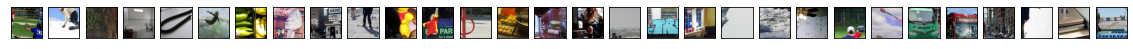

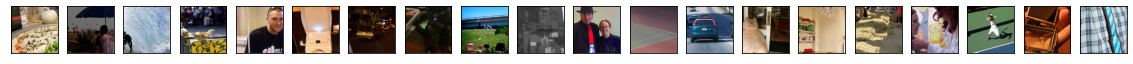

In [14]:
n=256
ram_parallel=[18, 8]
loaded=False

image_count_train = 3000
image_count_test = 500
image_size=[n, n, 3]
max_images_on_file=calculate_range(image_count_train, image_count_test, ram_parallel)
image_count = len(imgIds) # takes images from the entire COCO dataset
indexes = np.random.randint(0,len(imgIds),image_count)

print(" COCO DATASET LOADING")
print("**********************************************************************************")
print(" Metadata about loading")
print(" [META]: Images shape: " + str(image_size))
print(" [META]: Train set size: " + str(image_count_train))
print(" [META]: Test set size: " + str(image_count_test))
print_calculated_range(max_images_on_file, ram_parallel)
print("**********************************************************************************")

wanna_load=input(" Press [Drive] or [Coco]: ")
wanna_load=wanna_load.strip().lower()
print("**********************************************************************************")

if(wanna_load == "coco"):
  train, test=load_dataset_from_coco(dataDir, n, image_count_train, image_count_test, image_count, ram_parallel, max_images_on_file)
elif wanna_load == "drive":
  train, test=load_dataset_from_drive(dataDir, n, image_count_train, image_count_test, ram_parallel, max_images_on_file)
else:
  print(" [ERROR]: Datased failed to load.")

plot_figures(train, 30)
plot_figures(test, 20)

## Adding Noise

In [15]:
def truncnorm_(lower, upper, sigma):
  mu = (lower+upper)/2

  X = np.random.normal(mu, sigma)

  if(X < lower):
    return lower
  if(X > upper):
    return upper

  return X

### Apply noise to image
This function chooses randomly one kind of noise among Gaussian, Salt & Pepper and Speckle. 

Since we want more robustness, we decided to choose the intensity of the noise by using a gaussian distribution.

In [16]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  img = ((img*127.5) + 127.5).astype("uint8")
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.0051, 0.0081
    sigma = 0.0005
    var=np.random.uniform(low=lower,high=upper)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.011, 0.021
    sigma = 0.002

    amount=np.random.uniform(low=lower,high=upper)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.0051, 0.021
    sigma = 0.003

    var=np.random.uniform(low=lower,high=upper)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('[ERROR]: Wrong noise index.')
    return
    
  # random_noise returns [0,1] value
  # normalize images between [-1, 1]
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  #noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img = (noise_img - 127.5) / 127.5 ; 
  return noise_img

## Generatore - Discriminatore 

In [17]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [18]:
image_shape=image_size
print(image_size)

[256, 256, 3]


In [19]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [20]:
@tf.function
def preproces_vgg(x_):
    # scale from [-1,1] to [0, 255]
    x_ += 1.
    x_ *= 127.5

    # RGB -> BGR
    x_ = x_[..., ::-1]
    

    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    x_ = K.bias_add(x_, K.cast(_IMAGENET_MEAN, K.dtype(x_)))

    return x_

In [21]:
def vgg_loss(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=(256,256,3), 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False

    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)

    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    
    features_pred = features_extractor(preproces_vgg(y_pred))
    features_true = features_extractor(preproces_vgg(y_true))

    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

In [22]:
# Loss building blocks

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mse = keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
_vgg = None


def _get_vgg19():
    if _vgg is not None:
        return _vgg
    else:
        return keras.applications.VGG19(include_top=False, weights='imagenet')


def vgg19_loss(block_idx, conv_idx):
    mean = tf.constant([103.939, 116.779, 123.68])
    vgg = _get_vgg19()
    vgg_features = keras.models.Model(
        vgg.input,
        vgg.get_layer(f'block{block_idx}_conv{conv_idx}').output)

    def loss(y_true, y_pred):
        features_true = vgg_features((y_true * 255) - mean) / 12.75
        features_pred = vgg_features((y_pred * 255) - mean) / 12.75
        return mse(features_true, features_pred)

    return loss

In [23]:
from numpy.core.fromnumeric import resize
def define_generator(image_shape):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  # e1 = define_encoder_block(in_image, 64, batchnorm=False)
  # e2 = define_encoder_block(e1, 128)
  # e3 = define_encoder_block(e2, 256)
  # e4 = define_encoder_block(e3, 512)
  # e6 = define_encoder_block(e4, 512)

  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  # d1 = decoder_block(b, e6, 512)
  # d2 = decoder_block(d1, e5, 512)
  # d3 = decoder_block(d1, e4, 512)
  # d4 = decoder_block(d3, e3, 256, dropout=False)
  # d5 = decoder_block(d4, e2, 128, dropout=False)
  # d6 = decoder_block(d5, e1, 64, dropout=False)


  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)

  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image, name='Generator')
  
  return model

In [24]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_shape)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C512
	# d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)
	# second last output layer

	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)

	# patch output
	d = Flatten()(d)
	d = Dense(512, activation=None)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output_discriminator = Dense(1, activation='sigmoid')(d)

	# define model
	model = Model(in_image, output_discriminator, name='Discriminator')
	# compile model
	opt = Adam(learning_rate=0.5e-3, beta_1=0.6)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], loss_weights=[0.1])
	return model

In [25]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	#for layer in d_model.layers:
	#	if not isinstance(layer, BatchNormalization):
	#		layer.trainable = False
	# define the source image
	d_model.trainable = False
	in_src = Input(shape=image_shape)
	print(in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	############
	dis_out = d_model(gen_out)
	#dis_out = d_model(in_src)
	#############
	# src image as input, generated image and classification output
	model = Model(in_src, [gen_out, dis_out], name='GAN')
	#model = Model(in_src, dis_out, name='GAN')
	# compile model
	opt = Adam(learning_rate=0.7e-3, beta_1=0.9)
	#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])
	model.compile(loss=['mse', 'binary_crossentropy'], optimizer=opt, loss_weights=[1000., 0.01])
	return model


In [26]:
# define the models
d_model = define_discriminator(image_size)
g_model = define_generator(image_size)

In [27]:
# d_model.summary()

In [28]:
# g_model.summary()

In [29]:
# define the composite model
gan_model = define_gan(g_model, d_model, image_size)

(None, 256, 256, 3)


In [30]:
#gan_model.summary()

## Training

In [31]:
def gen_benchmark_images(img, index):
  noise_choises=["gaussian", "s&p", "speckle"];
  img = ((img*127.5) + 127.5).astype("uint8")
  if noise_choises[index]=="gaussian":
    mean=0;
    upper = 0.008
    lower=0.005
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=(upper+lower)/2)

  elif noise_choises[index]=="s&p":
    upper = 0.02
    lower=0.01
    noise_img = random_noise(img, mode='s&p', amount=(upper+lower)/2)

  elif noise_choises[index]=="speckle":
    upper = 0.02
    lower=0.005
    noise_img = random_noise(img, mode='speckle', var=(upper+lower)/2)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  #noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img = (noise_img - 127.5) / 127.5 
  return noise_img #random_noise returns [0,1] value

In [32]:
# select a batch of random samples, returns images and target
def generate_real_samples(i, batch_size, image_count_train):
  # choose random instances
  X = np.zeros((batch_size, 256, 256, 3))
  # retrieve selected images
  start=i*batch_size
  count=image_count_train-i*batch_size
  if count >= batch_size:
    end=(i+1)*batch_size-1 

  X=train[start:end+1]

  #plot_figures(X, batch_size)
    
  # generate 'real' class labels (1)
  y = np.ones(batch_size)
  #y = np.ones((n_samples, patch_shape, 1))
  return X , y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, batch_size, noisy_samples):
  # generate fake instance
  X = g_model.predict(noisy_samples)
  # create 'fake' class labels (0)
  y = np.zeros(batch_size)
  return X , y

In [33]:
def generate_noisy_samples(i, batch_size, image_count_train, n_batch):
  X_noisy = np.zeros((batch_size, 256, 256, 3))

  start=i*batch_size
  count=image_count_train-i*batch_size

  if count >= batch_size:
    end=(i+1)*batch_size-1 

  X_noisy=apply_noise_to_image(train[start:end+1])
  return X_noisy

In [34]:
def plot_losses(history, lim, epoch=0, type='', stamp=1):
  file_name='plot_'
  no_save = 0
  if type == 'loss':
    file_name=file_name+"loss_" + str(epoch) + ".png"
  elif type == 'accuracy':
    file_name=file_name+"accuracy_" + str(epoch) + ".png"
  else:
    no_save = 1
    
  path_file = os.path.join(directory_plots, file_name)
  pandas.DataFrame(history).plot(figsize=(20,16))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  if no_save != 1:
    plt.savefig(path_file)
  if stamp == 1:
    plt.show()

In [35]:
def PSNR_SSIM(original, noisy):
  mse = np.mean((original - noisy) ** 2)
  if(mse == 0):  # MSE is zero means no noise is present in the signal. Therefore PSNR have no importance.
      return 100, 1

  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse))
  ssim_ = ssim(original, noisy, data_range=noisy.max() - noisy.min(), multichannel=True)

  return psnr, ssim_

In [36]:
def performance_results(exec='train'):
  #########################################################
  # Calculate results from train and test set
  # (* stands for train/test)
  # raw_* = all value of PSNR and SSIM for all noises
  # avg_* = average value of PSNR and SSIM for all noises
  # max_* = max value of PSNR and SSIM for all noises
  #########################################################
  # Order is alway [PSNR, SSIM]
  #########################################################
  
  psnr_train=np.zeros((3, image_count_train))
  ssim_train=np.zeros((3, image_count_train))
  psnr_test=np.zeros((3, image_count_test))
  ssim_test=np.zeros((3, image_count_test))
  avg_psnr_test=[0, 0, 0]
  max_psnr_test=[0, 0, 0]
  avg_ssim_test=[0, 0, 0]
  max_ssim_test=[0, 0, 0]
  avg_psnr_train=[0, 0, 0]
  max_psnr_train=[0, 0, 0]
  avg_ssim_train=[0, 0, 0]
  max_ssim_train=[0, 0, 0]

  if exec == 'train' or 'all':
    for i in range(image_count_train):
      for j in range(3):
        bench=gen_benchmark_images(train[i], j)
        bench=np.expand_dims(bench, axis=0)
        denoised_image=g_model.predict(bench)
        psnr_train[j][i], ssim_train[j][i]=PSNR_SSIM(train[i], denoised_image[0])
    
    for j in range(3):
      avg_psnr_train[j]=sum(psnr_train[j])/image_count_train
      avg_ssim_train[j]=sum(ssim_train[j])/image_count_train
      max_psnr_train[j]=max(psnr_train[j])
      max_ssim_train[j]=max(ssim_train[j])
    
    raw_train=[psnr_train, ssim_train]
    avg_train=[avg_psnr_train, avg_ssim_train]
    max_train=[max_psnr_train, max_ssim_train]

  if exec == 'all':
    for i in range(image_count_test):
      for j in range(3):
        bench=gen_benchmark_images(test[i], j)
        bench=np.expand_dims(bench, axis=0)
        denoised_image=g_model.predict(bench)
        psnr_test[j][i], ssim_test[j][i]=PSNR_SSIM(test[i], denoised_image[0]) 

    for j in range(3):
      avg_psnr_test[j]=sum(psnr_test[j])/image_count_test
      avg_ssim_test[j]=sum(ssim_test[j])/image_count_test
      max_psnr_test[j]=max(psnr_test[j])
      max_ssim_test[j]=max(ssim_test[j])

    raw_test=[psnr_test, ssim_test]
    avg_test=[avg_psnr_test, avg_ssim_test]
    max_test=[max_psnr_test, max_ssim_test]

  return raw_train, avg_train, max_train, raw_test, avg_test, max_test

In [96]:
def reset_models_plots(directory_models, directory_history, directory_plots):
# deleting content of directory of models
  for dir in directory_models:
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))

# deleting content of directory of history
  for dir in directory_history:
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))

# deleting plot imgages
  for filename in os.listdir(directory_plots):
      file_path = os.path.join(directory_plots, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))
  return

In [68]:
def performance_benchmark(real, denoised):
  bench_psnr=[0, 0, 0]
  bench_ssim=[0, 0, 0]
  
  for i in range(3):
    bench_psnr[i], bench_ssim[i]=PSNR_SSIM(real, denoised[i])

  return bench_psnr, bench_ssim

In [107]:
def set_model_directory(directory_models, directory_history):
  directory_gan=os.path.join(directory_models, 'gan')
  directory_gen=os.path.join(directory_models, 'generator')
  directory_discr=os.path.join(directory_models, 'discr')  
  directory_losses=os.path.join(directory_history, 'losses')
  directory_accuracy=os.path.join(directory_history, 'accuracy')

  if not os.path.exists(directory_gan):
    os.mkdir(directory_gan)
  if not os.path.exists(directory_gen):
    os.mkdir(directory_gen)
  if not os.path.exists(directory_discr):
    os.mkdir(directory_discr)
  if not os.path.exists(directory_losses):
    os.mkdir(directory_losses)
  if not os.path.exists(directory_accuracy):
    os.mkdir(directory_accuracy)    

  return [directory_gan, directory_gen, directory_discr], [directory_history, directory_accuracy]

In [92]:
def save_models(directory_models, directory_history, epoch, gan_model, g_model, d_model, losses, accuracy):
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  directory_losses=directory_history[0]
  directory_accuracy=directory_history[1]

  gan_model.save(os.path.join(directory_gan, str(epoch) + ".h5"))
  g_model.save(os.path.join(directory_gen, str(epoch) + ".h5"))
  d_model.save(os.path.join(directory_discr, str(epoch) + ".h5"))
  np.save(os.path.join(directory_losses, str(epoch) + ".npy"), losses) 
  np.save(os.path.join(directory_accuracy, str(epoch) + ".npy"), accuracy) 

  return

In [94]:
def load_models(directory_models, directory_history, epoch):
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  directory_losses=directory_history[0]
  directory_accuracy=directory_history[1]

  file_name=str(epoch) + ".h5"
  path_gan=os.path.join(directory_gan, file_name)
  path_gen=os.path.join(directory_gen, file_name)
  path_discr=os.path.join(directory_discr, file_name)
  path_losses=os.path.join(directory_losses, file_name)
  path_accuracy=os.path.join(directory_accuracy, file_name)

  if not os.path.exists(path_gan) or not os.path.exists(path_gen) or not os.path.exists(path_discr) or not os.path.exists(path_losses) or not os.path.exists(path_accuracy):
    print(" [ERROR]: Path not found.")
    return 
  
  gan_model=keras.models.load_model(path_gan)
  gen_model=keras.models.load_model(path_gen)
  discr_model=keras.models.load_model(path_discr)

  losses = np.load(path_losses,allow_pickle='TRUE').item()
  accuracy = np.load(path_accuracy,allow_pickle='TRUE').item()
  
  return gan_model, gen_model, discr_model, losses, accuracy

In [103]:
def training(d_model, g_model, gan_model, n_epochs=100, batch_size=8, load=False, epoch_to_load=-1):
  
  n_batch = int(image_count_train / batch_size)
  print(" Train GAN Denoising")
  print("****************************************")
  print(" [META]: Metadata about training:")
  print(" [META]: Train dataset size: "+ str(image_count_train))
  print(" [META]: Number of epochs: "+ str(n_epochs))
  print(" [META]: N batch to process: "+ str(n_batch))
  print(" [META]: Batch Size: "+ str(batch_size))
  print("****************************************")

  # store benchmark images per epoch
  benchmarkImages=np.zeros((4, 256, 256, 3))
  benchmarkImages[0]=train[0]
  benchmarkImages[1]=gen_benchmark_images(train[0], 0)
  benchmarkImages[2]=gen_benchmark_images(train[0], 1)
  benchmarkImages[3]=gen_benchmark_images(train[0], 2)
  print(" [TRAIN]: Printing benchmarkImages ...")
  plot_figures(benchmarkImages, 4, figsize=(20,20), dpi=20)
  print("****************************************")
  benchmarkImages = np.reshape(benchmarkImages, (benchmarkImages.shape[0], benchmarkImages.shape[1], benchmarkImages.shape[2], benchmarkImages.shape[3]))

  # set path for different directory where storage gan, discriminator and generator models
  directory_models, directory_history=set_model_directory(path_models, path_history)
  
  if load is False:
    # resetting previous models and plots saved
    reset_models_plots(directory_models, directory_history, directory_plots) 
    epoch=0
  else:
    # load model 
    gan_model, g_model, d_model, losses_, accuracy_=load_models(directory_models, directory_history, epoch_to_load)
    losses=losses_
    accuracy=accuracy_
    epoch=epoch_to_load+1
  
  print(" [TRAIN]: Starting training ...")

  # manually enumerate epochs
  while epoch < n_epochs:
    #print("Epoch "+ str(epoch))

    for i in range(n_batch):
      #Generate noisy images
      # select a batch of real and fake samples 
      X_real, y_real= generate_real_samples(i, batch_size, image_count_train)
      X_noisy = generate_noisy_samples(i, batch_size, image_count_train, n_batch)

      #####################
      # train discriminator
      if epoch%2 == 0 and epoch != 0: 
        d_model.trainable = False
      else:
        d_model.trainable = True

      #d_model.trainable = True
      
      # generate a batch of fake samples
      X_gen, y_fake = generate_fake_samples(g_model, batch_size, X_noisy)
      # update discriminator for original samples
      d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
      losses['D_loss_true'].append(d_loss1)
      losses['Acc_true'].append(d_acc1)
      # update discriminator for noisy samples
      d_loss2, d_acc2 = d_model.train_on_batch(X_gen, y_fake)
      losses['D_loss_fake'].append(d_loss2)
      accuracy['Acc_fake'].append(d_acc2)
      
      ########################
      # train generator
      d_model.trainable = False
      fake_labels = [1] * batch_size
      fake_labels = np.reshape(fake_labels, (-1,))
      g_loss, g_mse, g_bce = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])
      losses['G_loss'].append(g_loss)

      percentage = "{:.2%}".format((i+1)/n_batch)
      message="[TRAIN]: [Epoch "+str(epoch)+"] -> Train process: " + percentage
      print("\r", message, end="")

    print(" ")
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: Discriminator Loss true " + str(d_loss1)+  " ( "  + str(d_acc1) + " ) - Discriminator Loss fake " + str(d_loss2) + " ( "  + str(d_acc2) + " )") 
    print("                     Generator Loss " + str(g_loss) + " ("  + str(g_mse) +" [MSE] + "  + str(g_bce) + " [BCE])")

    # it is important to regularly visualize the output
    images= np.zeros((3, 256, 256, 3))
    images=g_model.predict(benchmarkImages[1:4])

 #   if epoch % 1 == 0 and epoch != 0:
    bench_psnr, bench_ssim = performance_benchmark(benchmarkImages[0], images)
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: [PSNR]: { " + str(bench_psnr[0]) + ", " + str(bench_psnr[1]) + ", " + str(bench_psnr[2])+ "}") 
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: [SSIM]: { " + str(bench_ssim[0]) + ", " + str(bench_ssim[1]) + ", " + str(bench_ssim[2])+ "}") 

    plot_losses(losses, 20, epoch, 'loss', stamp=0)
    plot_losses(accuracy, 1, epoch, 'accuracy', stamp=0)

    save_models(directory_models, directory_history, epoch, gan_model, g_model, d_model, losses, accuracy)

    epoch = epoch + 1
    plot_figures(images,3, figsize=(20,20), dpi=20)
  return 

In [98]:
def check_model_directory(path_models):
  directory_models,_ =set_model_directory(path_models, path_history)
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  
  epoch_found="{"
  check=False

  for filename_gan in os.listdir(directory_gan):
    for filename_gen in os.listdir(directory_gen):
      if filename_gan == filename_gen:
        for filename_discr in os.listdir(directory_discr):
          if filename_discr == filename_gan:
            check=True
            epoch=filename_discr.split(".")[0]
            epoch_found=epoch_found +epoch + ", "
  size=len(epoch_found)
  epoch_found=epoch_found[:size-2]
  epoch_found=epoch_found+"}"
  return check, epoch_found

 Train GAN Denoising
****************************************
 [META]: Metadata about training:
 [META]: Train dataset size: 3000
 [META]: Number of epochs: 75
 [META]: N batch to process: 53
 [META]: Batch Size: 56
****************************************
 [TRAIN]: Printing benchmarkImages ...


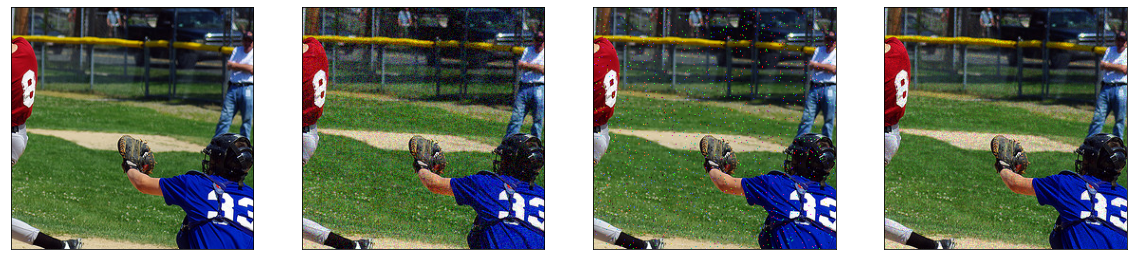

****************************************


FileNotFoundError: ignored

In [108]:
# train model
# define collections of metrics
losses={}
losses['G_loss'] = []
losses['D_loss_true'] = []
losses['D_loss_fake'] = []
accuracy = {}
accuracy['Acc_true'] = []
accuracy['Acc_fake'] = []

path_models='drive/MyDrive/ML-denoising/models'
path_history='drive/MyDrive/ML-denoising/history'
directory_plots='drive/MyDrive/ML-denoising/plots'

check=False
epoch=0
check, epoch_found=check_model_directory(path_models)
if check is True:
  print(" Pre-Train GAN Denoising Utils")
  print("****************************************")
  print(" Found saved models from epoch: " + epoch_found)
  wanna_load=input(" Want to load? Press [y] or [n]: ")
  wanna_load=wanna_load.strip().lower()
  if wanna_load == "y":
    epoch_str=input(" Which epoch do you want to resume? ")
    epoch=int(epoch_str)
  else:
    check=False
  print("****************************************")


training(d_model, g_model, gan_model, n_epochs=75, batch_size=56, load=check, epoch_to_load=epoch)

In [64]:
directory_models=set_model_directory(path_models)
_,test_gen,_=load_models(directory_models, 0)

test_gen.

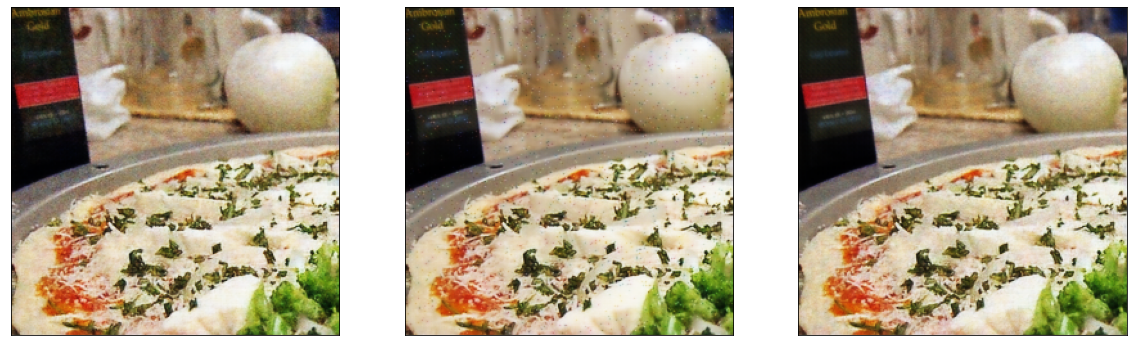

In [66]:
benchmarkImages_=np.zeros((4, 256, 256, 3))
benchmarkImages_[0]=test[4]
benchmarkImages_[1]=gen_benchmark_images(test[0], 0)
benchmarkImages_[2]=gen_benchmark_images(test[0], 1)
benchmarkImages_[3]=gen_benchmark_images(test[0], 2)
images_test=test_gen.predict(benchmarkImages_[1:4])

plot_figures(images_test,3)

In [ ]:
#psnr_test, ssim_test = performance_results('all')
# necessario elaborare questi risultati
